# 2019136011 권성민 딥러닝및실습 HW03

# Full Code

## Init Setting

In [34]:
import os
import torch
import wandb
import argparse
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path
from datetime import datetime
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
from torchinfo import summary
from random import randint


FILE_PATH = str(Path('C:/Users/00kwo/Desktop').resolve())
#FILE_PATH = 'C:/Users/KwonSungMin/Desktop'
BASE_PATH = str(Path('../../').resolve())

import sys
sys.path.append(BASE_PATH)
CHECKPOINT_FILE_PATH = os.path.join(FILE_PATH, "checkpoints")
  
print(BASE_PATH)
print(FILE_PATH)
print(CHECKPOINT_FILE_PATH)

C:\Users\00kwo\Desktop\딥러닝\link_dl
C:\Users\00kwo\Desktop
C:\Users\00kwo\Desktop\checkpoints


### DATA String 

In [2]:
from string import Template
class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)
def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

## Arg Parser

In [3]:
def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="Wandb: True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2_048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-3, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=10,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=10,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.00001,
    help="Delta value of early stop (float, default: 0.00001)"
  )

  parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
  )

  parser.add_argument(
    "--dropout", action=argparse.BooleanOptionalAction, default=False, help="Dropout: True or False"
  )

  return parser

## Load Dataset

In [17]:
from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

mean = 0.0
variance = 0.0

def get_fashion_mnist_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))
  print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

  num_data_loading_workers =  get_num_cpu_cores() if is_linux() or is_windows() else 0
  print("Number of Data Loading Workers:", num_data_loading_workers)

  train_data_loader = DataLoader(
    dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  global mean, variance
  mean = 0.0
  num = 0
  for i in range(len(f_mnist_train)):
      image, label = f_mnist_train[i]
      mean += image.sum()  
      num += image.numel() 
  mean /= num
  for i in range(len(f_mnist_train)):
    image, label = f_mnist_train[i]
    variance += ((image - mean) ** 2).sum()
  variance /= num

  validation_data_loader = DataLoader(
    dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=variance), # mean = 0.2860 , variance = 0.1246
  )

  return train_data_loader, validation_data_loader, f_mnist_transforms


def get_fashion_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
  f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

  print("Num Test Samples: ", len(f_mnist_test))
  print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

  test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.1246),
  )

  return f_mnist_test_images, test_data_loader, f_mnist_transforms

## Model

In [5]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()
      self.model = nn.Sequential(
        # batch*1*28*28
        nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=(5, 5), stride=(1, 1)),
        # batch*8*24*24
        nn.BatchNorm2d(num_features=8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # batch*8*12*12
        nn.Dropout(0.5),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # batch16*8*8
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # batch*16*4*4
        nn.Flatten(),
        nn.Linear(in_features=256, out_features=128),
        nn.BatchNorm1d(num_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.BatchNorm1d(num_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x
      
  my_model = MyModel(in_channels=1, n_output=10)
  return my_model

## Early stopping & Model saving

In [6]:
class EarlyStopping:
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    
    if not os.path.isdir(checkpoint_file_path):
      os.makedirs(checkpoint_file_path)
      
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False
        
    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"
    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

## Training

In [7]:
class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train() 

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()  

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

## Training Entry point

In [8]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
  }

  project_name = "homework03_mnist"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="2019136011 homework03",
    tags=["cnn", "mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
  print()
  f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()
  
  print("------------------------")
  print("mean : ", mean)
  print("variance", variance)
  print("------------------------")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  summary(model=model, input_size=(1, 1, 28, 28))

  optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=args.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

## Training Entry

In [9]:
if __name__ == "__main__":
  parser = get_parser()
  
  sys.argv = ["script.py", "--wandb", "-b", "64", "-r", "1e-4", "-v", "10", "-w", "0.005"]
  args = parser.parse_args()
  main(args)  
  

wandb: Currently logged in as: 00kwonsm. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=64, epochs=10000, learning_rate=0.0001, validation_intervals=10, early_stop_patience=10, early_stop_delta=1e-05, weight_decay=0.005, dropout=False)
{'epochs': 10000, 'batch_size': 64, 'validation_intervals': 10, 'learning_rate': 0.0001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05, 'weight_decay': 0.005}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 12

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
------------------------
mean :  tensor(0.2859)
variance tensor(0.1246)
------------------------
[Epoch   1] T_loss: 1.15896, T_accuracy: 64.8927 | V_loss: 0.82624, V_accuracy: 73.0400 | Early stopping is stated! | T_time: 00:00:31, T_speed: 0.032
[Epoch  10] T_loss: 0.40817, T_accuracy: 85.4982 | V_loss: 0.36991, V_accuracy: 86.3000 | V_loss decreased (0.82624 --> 0.36991). Saving model... | T_time: 00:03:51, T_speed: 0.043
[E

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▆▇▇▇▇██████████████████████████████████
Training loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇██████████▇▇▇▇▇▇▇▇▇▇▇█████████████████
Validation accuracy (%),▁▆▇▇▇▇██████████████████████████████████
Validation loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,540
Training accuracy (%),91.91636
Training loss,0.23739
Training speed (epochs/sec.),0.0443
Validation accuracy (%),91.6


## ClassificationTester

In [26]:
class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.transforms = transforms

    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))

    self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

  def test(self):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
      for test_batch in self.test_data_loader:
        input_test, target_test = test_batch

        input_test = self.transforms(input_test)

        output_test = self.model(input_test)

        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

        num_tested_samples += len(input_test)

      test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

  def test_single(self, input_test):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    with torch.no_grad():
      input_test = self.transforms(input_test)

      output_test = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

    return predicted_test.item()

## Test Entry

In [75]:
def main_t():
  project_name = "homework03_mnist"

  f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

  model = get_model()

  classification_tester = ClassificationTester(project_name, model, test_data_loader, f_mnist_transforms, CHECKPOINT_FILE_PATH)
  classification_tester.test()
  print()

  for i in range(10):
    index = randint(0, len(f_mnist_test_images))
    img, label = f_mnist_test_images[index]
    print("     LABEL:", label)
    # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
    output = classification_tester.test_single(
      torch.tensor(np.array(f_mnist_test_images[index][0])).unsqueeze(dim=0).unsqueeze(dim=0)
    )
    print("PREDICTION:", output)
    plt.imshow(img)
    plt.show()


# Network Model Analysis

![](./images/NetworkModel.png)


네트워크 구성은 위와 같다. Convolution & Pooling 연산을 통해서 width와 height를 2번 줄인 다음에 Fully Connect Network를 통해서 predict한다.
이때 transform으로 정규분포에 따르게 변경하고 진행하는데 ReLU activation function으로 하기에 x <= 0 일 경우 vanishing gradient problem이 발생할 수 있다.
따라서 Batch Normalization을 통해서 shift, scale 등을 통해 이 문제를 해결할 수 있다.

그리고 Convolution Block의 순서는 Conv->BatchNorm->Relu->Maxpooling 순으로 했다.
flatten을 진행한 후에 Fully Connected network의 경우 전통적인 방식을 따라서 했다. (이유는 밑 참조)


![](./images/initial%20model.png)


초기에 네트워크를 구성할 때에는 위와 같이 Convolution Block을 Convolution -> MaxPooling -> BatchNorm -> ReLU 순서로 했었다.
하지만 하이퍼 파라미터를 계속해서 조정해도 89%대에서 잘 안 넘어가는 문제가 있었다.
그래서 어떻게 Network를 구성하는게 좋을지 고민을 하게 되었다. 
그렇게 찾아본 결과 일반적으로 Pooling 연산은 activation 연산을 통해서 값을 얻고 Pooling을 통해서 중요한 특징만 남기게 필터링한다고 한다.
이에 반해 초기 버전에서는 convolution으로 데이터를 손실시키고 activation function을 거치기 때문에 오히려 손실만 발생하지 않았나 싶다.

초기에 flatten 후 진행하는 것도 Global Pooling을 통하면 네트워크를 크기를 줄일 수 있기 때문에 좋지 않을까 싶었다.
하지만 이것 또한 좋은 성능으로 이어지지 않은 것 같다. 
그 이유로 짐작하기로는 이전 Convolution Block이 shallow 하기 때문에 선형적인 것을 비선형 적으로 만드는 연산이 너무 적지 않았나 싶다.
따라서 기존 전통적인 방식으로 FCN->FCN->FCN 방식을 차용하지만 BatchNorm을 추가하여서 vanishing gradient problem을 방지하고, 더 좋은 결과로 낼 수 있게 설계를 진행하였다.

# Problem 01

![](./images/problem01_code.png)

![](./images/problem01.png)


mean과 variance는 train 이미지 데이터 셋을 기준으로 구한다.
float의 부동소수점 문제로 인하여 data load를 할 때마다 매번 달라진다. 
하지만 일반적으로는 위와 같이 mean은 0.2860, variance는 0.1246으로 나온다.

# Problem 02

wandb.ai link : https://wandb.ai/00kwonsm/homework03_mnist?workspace=user-00kwonsm

![](./images/problem02_wandb%20loss.png)
![](./images/problem02_wandb%20accuracy.png)
![](./images/problem02_run%20history.png)

In [69]:
summary_model = get_model()
summary(model=summary_model, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 8, 24, 24]            208
│    └─BatchNorm2d: 2-2                  [1, 8, 24, 24]            16
│    └─ReLU: 2-3                         [1, 8, 24, 24]            --
│    └─MaxPool2d: 2-4                    [1, 8, 12, 12]            --
│    └─Dropout: 2-5                      [1, 8, 12, 12]            --
│    └─Conv2d: 2-6                       [1, 16, 8, 8]             3,216
│    └─BatchNorm2d: 2-7                  [1, 16, 8, 8]             32
│    └─ReLU: 2-8                         [1, 16, 8, 8]             --
│    └─MaxPool2d: 2-9                    [1, 16, 4, 4]             --
│    └─Flatten: 2-10                     [1, 256]                  --
│    └─Linear: 2-11                      [1, 128]                  32,896
│    └─

Hyper Parameter
  * Learning Rate : 1e-4
  * Batch Size :  64
  * Early Stop Patience : 10
  * Weight Decay Value : 0.005
  * Normalization Type : Batch Normalization
  * Dropout Rate : 0.5

GPU 연산을 많이 사용하지 않았기 때문에 Batch Size를 1024 2048 5000 등 늘려서 실험해본 적이 있었다.
하지만 이렇게 할 경우 너무 많은 케이스를 보고 feedback하기 때문인지 학습이 느리게 진행되고 잘 안되는 것을 볼 수 있었다.
이에 반해 Batch size를 64로 하니까 빠르게 gradient가 좋은 쪽으로 가는 것을 볼 수 있었다. 따라서 batch size를 64로 진행하였다.

Learning rate의 경우 1e-2, 1e-3, 1e-4로 조금씩 모델도 수정해보면서 확인해본 결과 1e-4가 가장 좋은 결과가 나와서 유지했다.


## Problem 03

In [74]:
  project_name = "homework03_mnist"

  f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

  model = get_model()

  classification_tester = ClassificationTester(project_name, model, test_data_loader, f_mnist_transforms, CHECKPOINT_FILE_PATH)
  classification_tester.test()

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: C:\Users\00kwo\Desktop\checkpoints\homework03_mnist_checkpoint_latest.pt
TEST RESULTS: 91.090%


# Problem 04

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: C:\Users\00kwo\Desktop\checkpoints\homework03_mnist_checkpoint_latest.pt
TEST RESULTS: 91.090%

     LABEL: 0
PREDICTION: 0


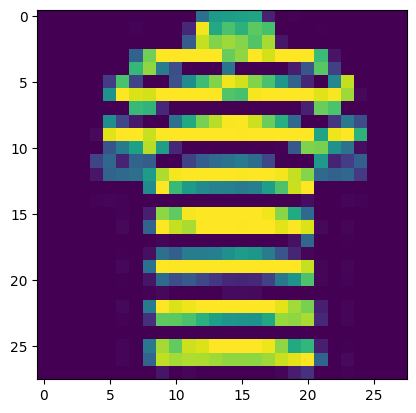

     LABEL: 7
PREDICTION: 7


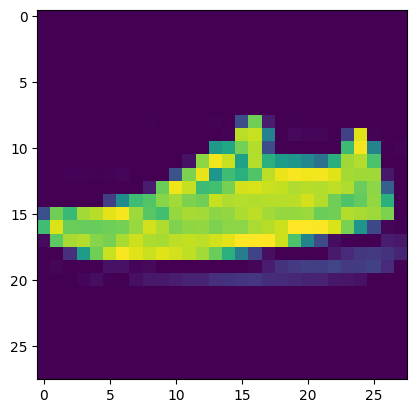

     LABEL: 8
PREDICTION: 8


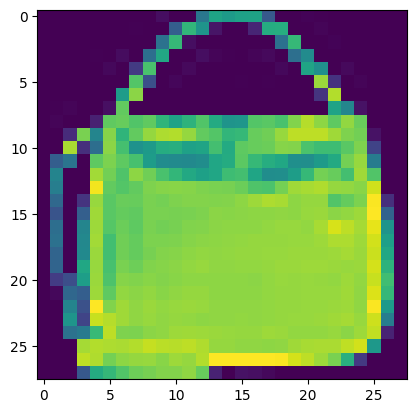

     LABEL: 2
PREDICTION: 2


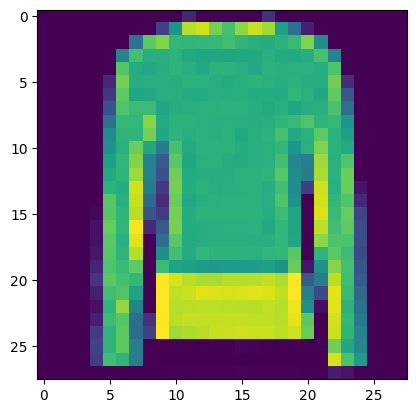

     LABEL: 5
PREDICTION: 5


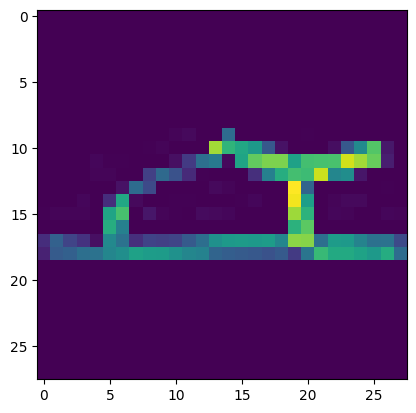

     LABEL: 0
PREDICTION: 0


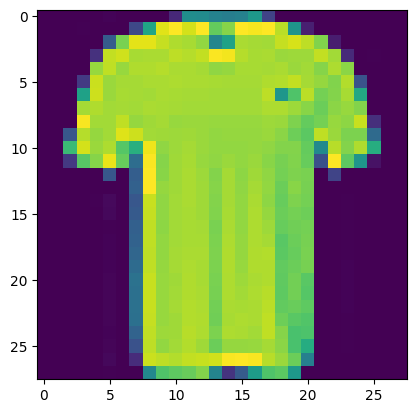

     LABEL: 8
PREDICTION: 8


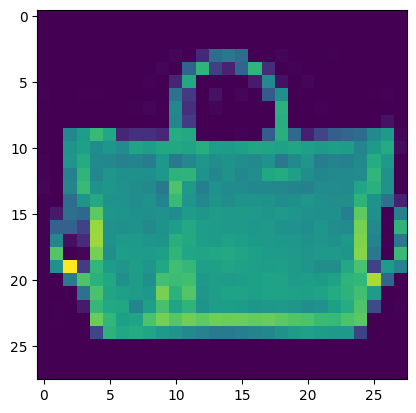

     LABEL: 0
PREDICTION: 0


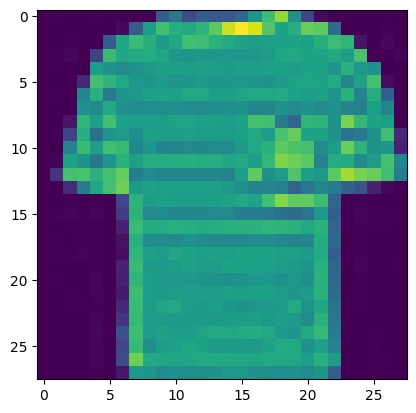

     LABEL: 6
PREDICTION: 2


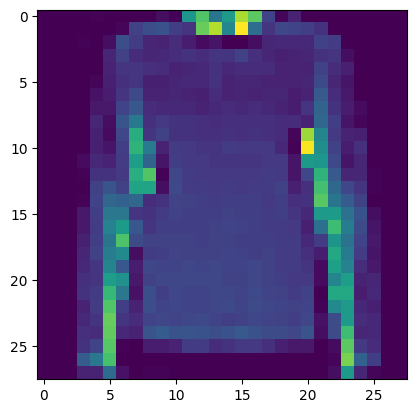

     LABEL: 5
PREDICTION: 5


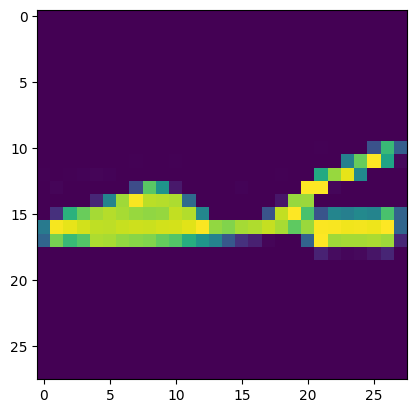

In [77]:
if __name__ == "__main__":
  main_t() 

내가 생각하는 성능이 더 좋게 나오지 않은 이유는 Network model이 shallow 하기 때문에 activation function이 적어 비선형적인 변화를 줄 수 없기 때문이라고 본다.

![](./images/compare.png)

실제 틀린 사진과 정답인 사진을 보면 사람이 보기에도 큰 차이를 느낄 수 없다는 것을 볼 수 있다.
따라서 조금 더 deep하게 model을 만들 경우에 사람은 알 수 없지만 내부적으로 이를 잘 구분할 수 있는 모델이 만들어지지 않을까 싶다.
물론 이것이 overfitting으로 판단될 수 있다는 문제가 있지만 데이터 셋의 해상도가 좋지 않다보니 발생하는 어쩔 수 없는 문제라고 생각이 든다.

# 숙제 후기

Accuracy 91%를 넘기기 위해서 여러 실험을 하기도 하고, 선배님들께 여쭤보기도 했다.
작업관리자로 GPU 사용률을 확인해보았을 때 생각보다 GPU 자원을 얼마 쓰지 않았다.
이에 대해서 여쭤보니까 일반적으로 local 환경에 맞춰서 자원을 대부분 쓰게끔 네트워크 모델을 짜는게 첫 번째 단계라고 한다.
그리고 최적화 방법을 여러가지로 시도해 본 다음에 learning rate 등 하이퍼 파라미터를 수정해보면서 테스트 해보는게 좋을 것 같다고 하셨다.
이를 통해서 GPU의 자원을 대부분 쓸 수 있게 네트워크 모델을 크게 만들고 이에 대해서 많은 테스트를 진행할 수 있었다.
하지만 결과적으로 좋지 않은 결과가 나왔다. 여쭤본 결과 항상 파라미터가 많다고 좋은 것이 아니라 학습하는데도 파라미터 전부를 수정하느냐고 좋지 않을 수 있다는 말씀을 해주셨다.
실제 task 자체가 크지 않기 때문에 자원을 전부 사용할 수 있게 Network를 짜는 것이 좋지 않다고 생각이 든다.

그 다음으로 궁금했던 점으로는 pooling 혹은 convolution 연산을 하면 feature 수를 얼마나 늘려야 되는지 여쭤보았다.
일반적으로는 pooling 시 데이터 손실이 발생하기 때문에 해상도가 절반으로 줄어들면 feature 수도 2배로 증가 시키는게 일반적이라고 하셨다.
덧붙여 말씀해주시는 것으로는 본인의 연구 분야인 image resolution에서는 세부적인 특징점을 찾기 위해서 같은 이미지 h*w로 유지하신다고 하셨다.
이에 반해 mnist train한 것과 같이 classification할 때는 어느정도 conv로 feature h*w를 줄이고서 하는게 성능이 더 좋을 것 같다고 하셨다. 

외에도 궁금한 점들을 여쭤보았고 답변을 들으면서 네트워크를 데이터 셋 및 task에 따라서 어떻게 만들어야 되는지 알 수 있는 시간이 되었다.